# Analysis on Grouped HealthCodes Gait Features

This notebook explores the gait features of grouped healthcodes coming from the active tests of Sage Bionetowrks mPower App and controls from ElevateMS study cohort. The goal of this notebook is to further understand how gait features on PD and non-PD varies accross different demographics cohort. The pipeline of how we retrieve this feature sets is documented on a repostitory of this github repository: <b>http://github.com/arytontediarjo/mpower-gait-analysis</b>. 

### Table of Contents:

##### 1. Introduction

##### 2. Raw Probability Distribution Visualization of Treatment and Control Groups

##### 3. Baseline Prediction and Embedded Feature Importances

##### 4. EDA on Important Features

## 1. Introduction

#### Explaining the Features:

So in our gait analysis, all the features will be annotated as following:
    
     (aggregation_type)_(axis)_(name of feature) 
    
Several aggregation types are chosen based on several aspects:
    
    - `median`: Due to its insensitivy to outliers in getting the general overview of the features
    - `std`: For deviation between each features
    - `iqr`: For capturing a more balanced difference between "ON" and "OFF" phase of a PD
    
#### Feature Descriptions:

- <b> Cadence </b>: Number of heel strikes per seconds
- <b>Energy Freeze Index</b>: Power in freeze band (high frequency band)/ Power in locomotor band (lower frequency band) 
- <b>Locomotor Freeze Index</b>: Power in freeze band (high frequency band) + Power in locomotor band (lower frequency band)
- <b>Average step/stride duration</b>: The average time duration between each step/stride
- <b>Std of step/Stride duration</b>: The standard deviation of time duration between each step/stride
- <b>Speed of gait</b>: gait speed from the energies of the approximation coefficients of wavelet functions
- <b>Step/stride regularity</b>: consistency of step/stride on a given x, y or z axis
- <b>Symmetry</b>: difference between step and stride regularity.
- <b>Rotation omega</b>: speed of turning (if it exists)    



#### Matched Users:

In our cohort anaysis, we will be using a matched healthcodes that has been subsampled to have no associations towards how likely they are to be PD or non-PD based on their own metadata (more information is addressed on the repo). Thus, by breaking the association of the metadata, our future models would not be dependent on what kind of metadata that the users might have. 

Link to matching documentation: https://github.com/arytontediarjo/mpower-gait-analysis/notebooks/matching_metadata.pdf

### Library Imports

In [3]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

#### Global Variables

In [4]:
WALKING_GROUPED_FEATURES = "syn21678699"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!




UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.0.0) is available. Your version (1.9.3) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.0.0 release notes

https://python-docs.synapse.org/build/html/news.html

INFO:synapseclient_default:Welcome, aryton tediarjo!



#### Helper Function

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data

def visualize_feature_importances(X_train, *models):
    for model in models:
        try:
            features = model.best_estimator_["classifier"].feature_importances_
        except:
            features = model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X_train.columns[model.best_estimator_["feature_selection"].get_support()]))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()

#### Get Gait Feature and Matched Demographic Datasets

In [6]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)


data = data[[feat for feat in data.columns if ("filepath" not in feat) 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]


# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(demographic[["healthCode"]], data, on = "healthCode", how = "inner")

# set healthcode as index
data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]][::-1]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

## 2. Baseline Model using Performance Random Forests

- Null values are imputed by median
- Random Forest with 1000 subtrees are used for model fitting
- Check feature importances based on Random Forest Model

In [7]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

In [8]:
# Create raw model with 1000 estimators
model = RandomForestClassifier(bootstrap = True,
                               n_estimators = 100,
                              random_state = 100)

# A simple median imputation on feature sets
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')


# split train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.25,
                                                   random_state = 100)
imp_median.fit(X_train)
X_train = imp_median.transform(X_train)
model.fit(X_train, y_train)

X_test = imp_median.transform(X_test)
y_pred = model.predict(X_test)

#### Base RF-Model Performance

In [9]:
get_results_dataframe(X_test, y_test, model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,RandomForestClassifier,NaN,NaN,0.648268,12.148265,0.643357


#### Classification Report

In [10]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65        74
           1       0.64      0.65      0.64        71

    accuracy                           0.65       145
   macro avg       0.65      0.65      0.65       145
weighted avg       0.65      0.65      0.65       145



#### Confusion Matrix

In [11]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             index = ["predicted: 0", "predicted: 1"], 
             columns = ["true: 0", "true: 1"])

,true: 0,true: 1
predicted: 0,48,26
predicted: 1,25,46


It seems that our base model using random forest has some capability of recognizing users that are PD and those who are not from our studies in, however, this is still a baseline model, and might be subject to change. Having an ROC-AUC of .64 is a good start that indicates that our feature data are actually giving out some signals for a model to learn.

#### Class Prediction Probability Distribution 

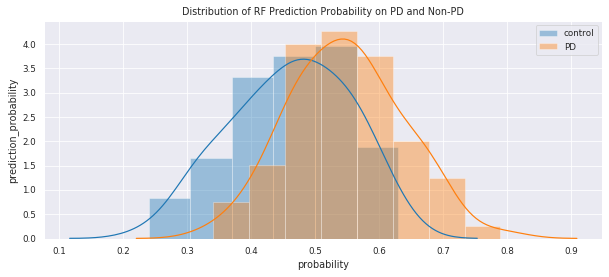

In [12]:
# get probability dataframe
proba = pd.DataFrame({"probability": model.predict_proba(X_test)[:,1], })
proba["class"] = y_test.reset_index(drop = True)
# plot probability distribution
plt.figure(figsize = (10,4))
sns.distplot(proba["probability"][proba["class"] == 0], label = "control")
sns.distplot(proba["probability"][proba["class"] == 1], label = "PD")
plt.legend()
plt.ylabel("prediction_probability")
plt.title("Distribution of RF Prediction Probability on PD and Non-PD")
plt.show()

#### Random Forest Embedded Feature Importances (Top 20)

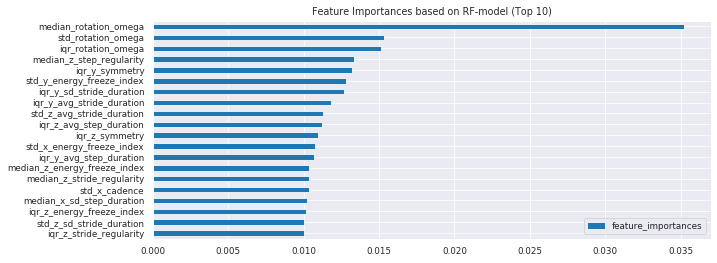

In [13]:
pd.DataFrame(data = model.feature_importances_, index = train.columns)\
.sort_values(0, ascending = True)\
.tail(20)\
.rename({0:"feature_importances"}, axis = 1)\
.plot(kind = "barh", figsize = (10,4))
plt.title("Feature Importances based on RF-model (Top 10)")
plt.show()

- Rotation omega is shown to be very indicative on differentiating PD vs non-PD as features related to rotation seems to be on top of the list on all kinds of aggregation types
- Most of the strong features features have strong signal in y-axis, and z axis which means that the features are capturing the fluctuation of steps from the phone orientation and shaking based on the z axis.
- However, our model might be highly bias towards the rotation speed as it far outweighs the other features

### 4. EDAs on High Scoring Features

In [14]:
data["age_group"] = pd.qcut(data["age"], q = 4)

#### a. Median Rotation Speed over Older Age

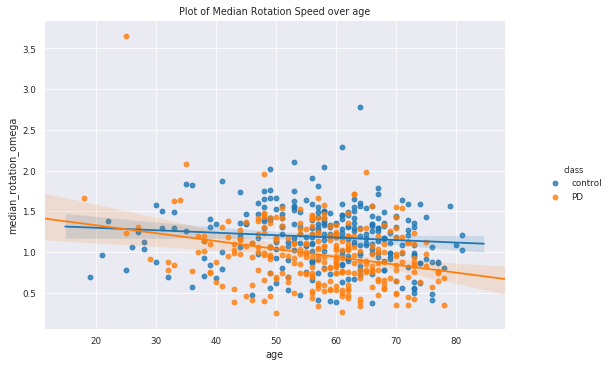

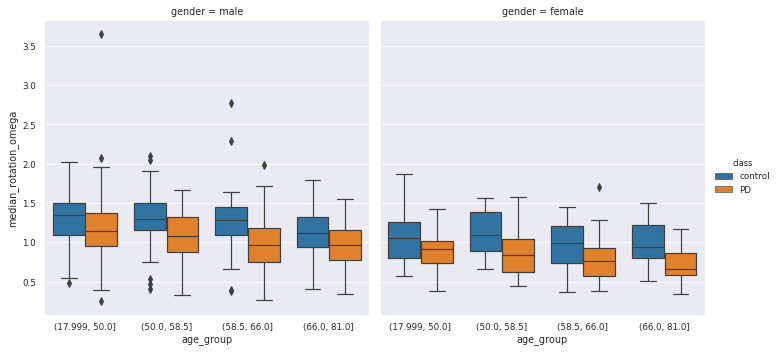

In [15]:
rotation = data[[feat for feat in data.columns if ("rotation_omega" in feat) or 
                       ("age" in feat) or ("gender" in feat) or ("class" in feat)]]
rotation  = rotation[rotation["median_rotation_omega"] > 0]


plot = sns.lmplot(y = "median_rotation_omega", x = "age", 
                  data = rotation, 
                  hue = "class", hue_order = ["control", "PD"])
plot.fig.set_size_inches(9,5)
plt.title("Plot of Median Rotation Speed over age")


sns.catplot(y = "median_rotation_omega", x = "age_group", 
           data = rotation, col = "gender",
            hue = "class",
            hue_order = ["control", "PD"],
           kind = "box", 
           height = 5)
plt.show()

- Difference between case vs control is notable in the box plot of median rotation speed, 
- As age is age-matched, impact of age is not apparent to the features, noted from the box plot being roughly similar on every age group

### b. Increase in Range and Deviation of Stride-Stride Duration

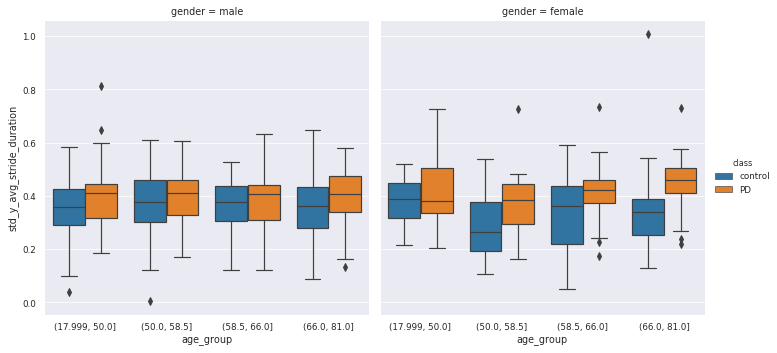

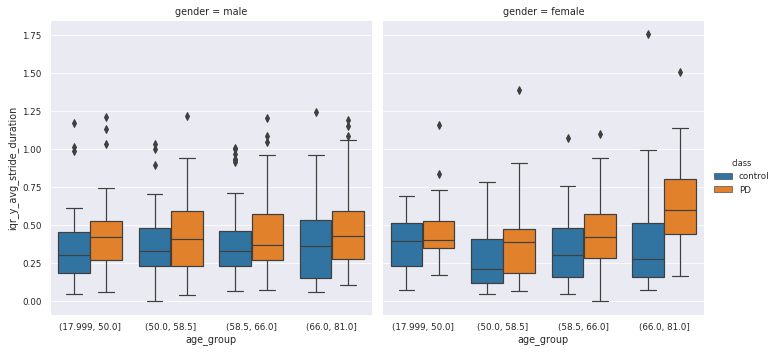

In [16]:
sns.catplot(y = "std_y_avg_stride_duration", x = "age_group", 
           data = data[["age_group", "std_y_avg_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order = ["control", "PD"],
           kind = "box", height = 5)



sns.catplot(y = "iqr_y_avg_stride_duration", x = "age_group", 
           data = data[["age_group", "iqr_y_avg_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",hue_order = ["control", "PD"],
           kind = "box", height = 5)

plt.show()

- Despite imbalance on distribution, we can see that PD has higher IQR of strides
- This can happen to festination period. where PD will freeze, unable to move, and accelerate involuntarily. Therefore there might be some cases where their duration from one stride to another will be really fast and really low whenever they are shuffling.

### c. Median Stride Regularity

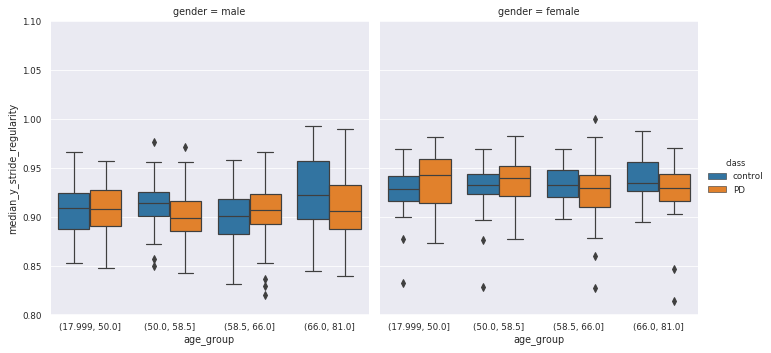

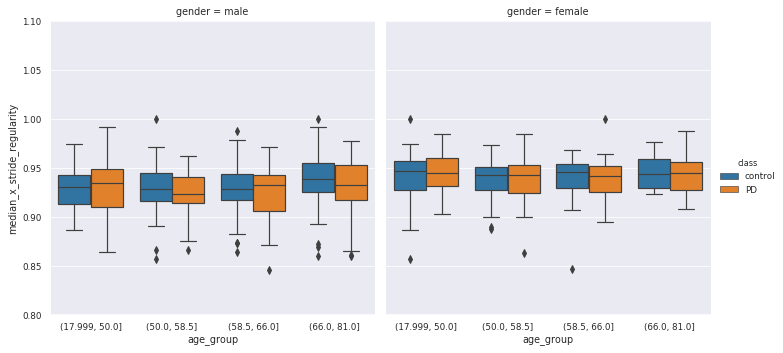

In [24]:
sns.catplot(y = "median_y_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_y_stride_regularity", "class", "gender"]].dropna(), 
            hue = "class", col = "gender", hue_order = ["control", "PD"],
           kind = "box", height = 5)
plt.ylim(0.8,1.1)
plt.show()

sns.catplot(y = "median_x_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_x_stride_regularity", "class", "gender"]].dropna(), 
            hue = "class", col = "gender", hue_order = ["control", "PD"],
           kind = "box", height = 5)
plt.ylim(0.8,1.1)
plt.show()


Median stride regularity on the different demographics seemed to have a trend as well as we can see that the median stride regularity, which measures how consistent the stride pattern is on the given axis seems to decrase as the age group increases. 

### d. Symmetry Interquartile Range on Different Demographics

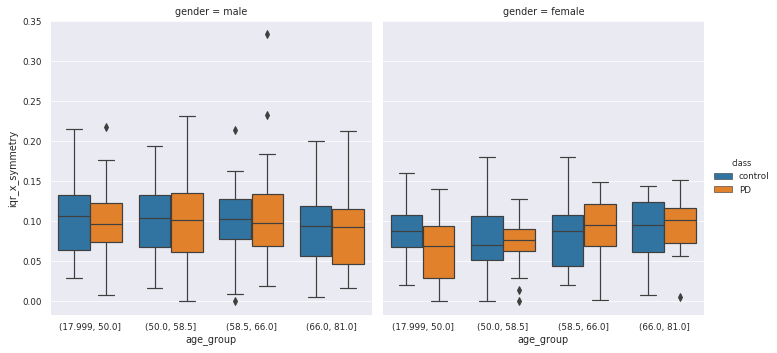

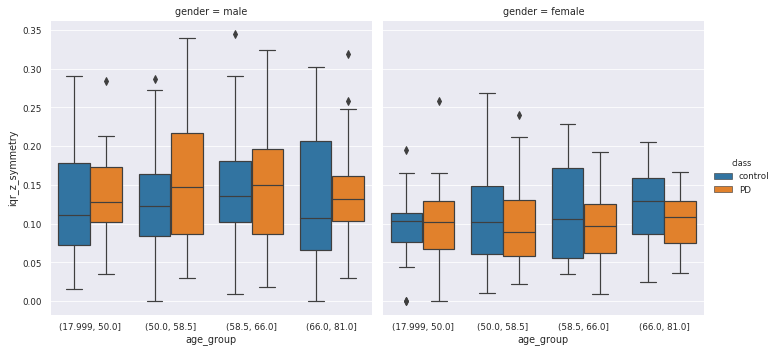

In [20]:
cat = sns.catplot(y = "iqr_x_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_x_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",hue_order = ["control", "PD"],
           kind = "box", height = 5)

cat = sns.catplot(y = "iqr_z_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_z_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",hue_order = ["control", "PD"],
           kind = "box", height = 5)

- The graph above shows that the interquartile range of the symmetry is very flucauative for

### e. Freeze Index

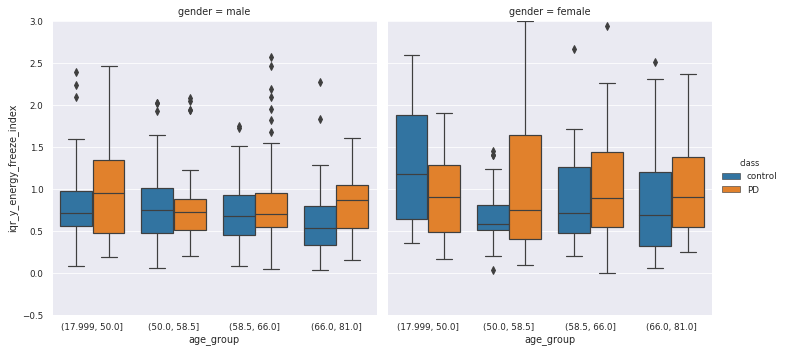

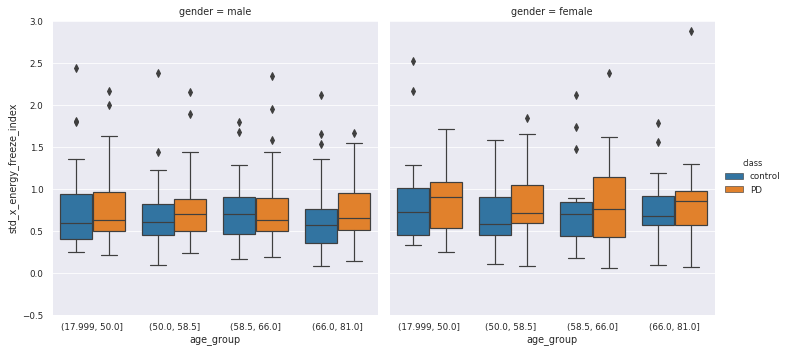

In [27]:
sns.catplot(y = "iqr_y_energy_freeze_index", x = "age_group", 
           data = data[["age_group", "iqr_y_energy_freeze_index", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order =["control", "PD"],
           kind = "box", height = 5)
plt.ylim(-0.5, 3)
plt.show()

sns.catplot(y = "std_x_energy_freeze_index", x = "age_group", 
           data = data[["age_group", "std_x_energy_freeze_index", "class", "gender"]].dropna(), 
            col = "gender", hue = "class", hue_order =["control", "PD"],
           kind = "box", height = 5)
plt.ylim(-0.5, 3)
plt.show()

- In terms of freeze index, we can see that PD generally has higher deviation, as their freeze index can change rapidly, due to festination

### Assessing Correlations between Gait Features

As we are using features that is based on aggregation, it is common to face highly correlated features.

In [19]:
print("Top Absolute Correlations")
get_top_abs_correlations(data[feat_cols], 20)

Top Absolute Correlations


median_AA_loco_freeze_index  median_AA_speed_of_gait         0.951497
std_AA_step_regularity       std_AA_stride_regularity        0.937679
iqr_x_energy_freeze_index    std_x_energy_freeze_index       0.931412
std_x_step_regularity        std_x_stride_regularity         0.916846
iqr_AA_speed_of_gait         std_AA_speed_of_gait            0.910365
iqr_AA_step_regularity       iqr_AA_stride_regularity        0.903543
median_AA_step_regularity    median_AA_stride_regularity     0.903465
median_z_avg_step_duration   median_z_avg_stride_duration    0.900375
median_x_avg_step_duration   median_x_avg_stride_duration    0.894610
median_AA_loco_freeze_index  median_x_loco_freeze_index      0.884078
iqr_AA_loco_freeze_index     iqr_AA_speed_of_gait            0.883310
iqr_z_loco_freeze_index      std_z_loco_freeze_index         0.883163
median_AA_loco_freeze_index  median_y_loco_freeze_index      0.882065
iqr_y_energy_freeze_index    std_y_energy_freeze_index       0.865910
iqr_AA_loco_freeze_i

## Results & Summary:

- Rotation Omega is far outweighing other features in comparison by embedded model feature importances
- There are some signal that can be captured by the signals, such as the stride-to-stride duration aggregated features (IQR, std) which is shown to be higher in PD 
- Stride Regularities are shown to be lower on PD as well, however this trend does not persist through different cohorts, as the trend changes on the female groups
- Freeze indexes is shown to be higher in PD, however this trend does not persist on the youngest female group
- Female youngest group, seems to have a trend that is contradicting to other age group, could be an indication that the users are not actually doing the test properly <b> (especially on young control user - will be analyzed further) </b>

### Future Ideas:
- Try out feature combination for reducing redundant features
- Try other subsamples of metadata
- Gather more data samples from Android
- Feature reduction and more QC on data that deviates from the normal distribution
- Analysis of z score based on each users